In [1]:
import os, sys, re, gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, BoxStyle
import glob

from utils import iou_xywh, assign_labels

%matplotlib inline

2021-03-20 22:20:14,538 - INFO - dataset:dataset.py:27 - dataset package is loaded...


In [2]:
with open('dataset/classes.txt', 'r') as f:
    classes = f.readlines()
    classes = [ c.strip() for c in classes]
classes

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox',
 'textarea',
 'label',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'radiobutton',
 'table',
 'n/a']

In [3]:
glob.glob('dataset/annotations/*.txt')

['dataset/annotations\\angular.txt',
 'dataset/annotations\\bootstrap-form.txt',
 'dataset/annotations\\bootstrap-forms.txt',
 'dataset/annotations\\bootstrap.txt',
 'dataset/annotations\\classes.txt',
 'dataset/annotations\\complex-table.txt',
 'dataset/annotations\\contact-form.txt',
 'dataset/annotations\\dates.txt',
 'dataset/annotations\\different-elemants.txt',
 'dataset/annotations\\different-elements.txt',
 'dataset/annotations\\html-5.txt',
 'dataset/annotations\\login.txt',
 'dataset/annotations\\metals-and-colors.txt',
 'dataset/annotations\\mobile-and-html-5.txt',
 'dataset/annotations\\performance.txt',
 'dataset/annotations\\react-ant.txt',
 'dataset/annotations\\search.txt',
 'dataset/annotations\\simple-table.txt',
 'dataset/annotations\\support.txt',
 'dataset/annotations\\table-with-pages.txt',
 'dataset/annotations\\user-table.txt']

In [4]:
glob.glob('dataset/images/*')

['dataset/images\\angular.png',
 'dataset/images\\bootstrap-form.png',
 'dataset/images\\bootstrap-forms.png',
 'dataset/images\\bootstrap.png',
 'dataset/images\\Capture.PNG',
 'dataset/images\\complex-table.png',
 'dataset/images\\contact-form.png',
 'dataset/images\\dates.png',
 'dataset/images\\different-elemants.png',
 'dataset/images\\dummy.png',
 'dataset/images\\html-5.png',
 'dataset/images\\login.png',
 'dataset/images\\metals-and-colors.png',
 'dataset/images\\mobile-and-html-5.png',
 'dataset/images\\performance.png',
 'dataset/images\\react-ant.png',
 'dataset/images\\search.png',
 'dataset/images\\support.png',
 'dataset/images\\table-with-pages.png',
 'dataset/images\\user-table.png']

In [5]:
glob.glob('dataset/df/*')

['dataset/df\\angular.parquet',
 'dataset/df\\bootstrap-form.parquet',
 'dataset/df\\bootstrap-forms.parquet',
 'dataset/df\\bootstrap.parquet',
 'dataset/df\\complex-table.parquet',
 'dataset/df\\contact-form.parquet',
 'dataset/df\\dates.parquet',
 'dataset/df\\different-elemants.parquet',
 'dataset/df\\dummy.parquet',
 'dataset/df\\html-5.parquet',
 'dataset/df\\login.parquet',
 'dataset/df\\metals-and-colors.parquet',
 'dataset/df\\mobile-and-html-5.parquet',
 'dataset/df\\performance.parquet',
 'dataset/df\\react-ant.parquet',
 'dataset/df\\search.parquet',
 'dataset/df\\support.parquet',
 'dataset/df\\table-with-pages.parquet',
 'dataset/df\\user-table.parquet']

In [6]:
annotations = { re.sub('^.*[/\\\]', '', fn).split('.')[0]: fn for fn in glob.glob('dataset/annotations/*.txt')}
parquets = { re.sub('^.*[/\\\]', '', fn).split('.')[0]: fn for fn in glob.glob('dataset/df/*.parquet')}
images = { re.sub('^.*[/\\\]', '', fn).split('.')[0]: fn for fn in glob.glob('dataset/images/*.png')}

In [7]:
pages = list((set(annotations.keys()).intersection(set(parquets.keys()))).intersection(set(images.keys())))

In [8]:
sorted(pages)

['angular',
 'bootstrap',
 'bootstrap-form',
 'bootstrap-forms',
 'complex-table',
 'contact-form',
 'dates',
 'different-elemants',
 'html-5',
 'login',
 'metals-and-colors',
 'mobile-and-html-5',
 'performance',
 'react-ant',
 'search',
 'support',
 'table-with-pages',
 'user-table']

In [9]:
# page_name = 'react-ant'
# page_name = 'metals-and-colors'
# page_name = 'user-table'
# page_name = 'table-with-pages'
# page_name = 'support'
# page_name = 'simple-table'
# page_name = 'search'
# page_name = 'performance'
# page_name = 'mobile-and-html-5'
# page_name = 'metals-and-colors'
# page_name = 'login'
page_name = 'html-5'
# page_name = 'different-elements'
# page_name = 'dates'
# page_name = 'contact-form'
# page_name = 'complex-table'
# page_name = 'bootstrap-form'
# page_name = 'angular'


In [10]:
_df = pd.read_parquet(parquets[page_name])
_ann = np.loadtxt(annotations[page_name])
_img = plt.imread(images[page_name])
_img = (_img[...,0] + _img[...,1] + _img[...,2])/3.0

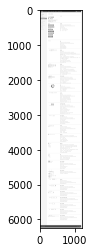

In [11]:
plt.imshow(_img, cmap='gray')

In [12]:
_boxes = _df[['x', 'y', 'width', 'height' ]].values

In [13]:
_boxes.shape

(665, 4)

In [14]:
from collections import OrderedDict

labels = []

for bb in _ann:
    c,x,y,w,h = bb
    x = (x - w/2) * _img.shape[1]
    y = (y - h/2) * _img.shape[0]
    w = w * _img.shape[1]
    h = h * _img.shape[0]

    best_iou = 0.0
    best_i = 0
    
    for i, r in enumerate(_boxes):
        
        if (r[2] <= 0) or (r[3] <= 0) or (r[0]<0) or (r[1] < 0) :
            continue
            
        _iou = iou_xywh((x,y,w,h), (r[0], r[1], r[2], r[3]))
        
        if _iou > best_iou:
            best_i, best_iou = (i, _iou)
    
    labels.append({'idx': best_i, 'label': c, 'iou': best_iou })

labels_df = pd.DataFrame(data=labels) #, index='idx')
labels_df.index = labels_df.idx
labels_df

,idx,label,iou
idx,,,
39,39,1.0,0.730082
37,37,1.0,0.662303
41,41,1.0,0.397827
43,43,1.0,0.368872
45,45,1.0,0.487473
...,...,...,...
220,220,0.0,0.845609
223,223,0.0,0.859081
95,95,0.0,0.395581


In [15]:
df_with_labels = _df.merge(labels_df, how='left', left_index=True, right_index=True)

In [16]:
df_with_labels.shape

(665, 16)

In [17]:
df_with_labels

,attributes,displayed,element_id,height,onmouseenter,onmouseover,parent_id,style,tag_name,text,width,x,y,idx,label,iou
0,"{'accept': None, 'alt': None, 'charset': None,...",True,6194400565668651573001447234,6225.0,None,None,None,"[align-content, align-items, align-self, align...",HTML,INFORMATION\nFRAMEWORK\nHOME\nCONTACT FORM\nSE...,1183.0,0.0,0.0,NaN,NaN,NaN
1,"{'accept': None, 'alt': None, 'charset': None,...",False,5940208781668651575354546745,0.0,None,None,6194400565668651573001447234,"[align-content, align-items, align-self, align...",HEAD,\n \n HTML 5\n \n \n \n \n ...,0.0,0.0,0.0,NaN,NaN,NaN
2,"{'accept': None, 'alt': None, 'charset': 'utf-...",False,0308574544668651577240038177,0.0,None,None,5940208781668651575354546745,"[align-content, align-items, align-self, align...",META,,0.0,0.0,0.0,NaN,NaN,NaN
3,"{'accept': None, 'alt': None, 'charset': None,...",False,7979784547668651574942432695,0.0,None,None,5940208781668651575354546745,"[align-content, align-items, align-self, align...",TITLE,HTML 5,0.0,0.0,0.0,NaN,NaN,NaN
4,"{'accept': None, 'alt': None, 'charset': None,...",False,4132022685668651575923761729,0.0,None,None,5940208781668651575354546745,"[align-content, align-items, align-self, align...",META,,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,"{'accept': None, 'alt': None, 'charset': None,...",False,7082388353668651593629350637,0.0,None,None,4205479405668651570823159925,"[align-content, align-items, align-self, align...",SCRIPT,\n function show_val(element) {\n\t\tconst ...,0.0,0.0,0.0,NaN,NaN,NaN
661,"{'accept': None, 'alt': None, 'charset': None,...",False,7888289840668651595439231536,0.0,None,None,4205479405668651570823159925,"[align-content, align-items, align-self, align...",SCRIPT,\n $('#multi-dropdown').multiselect();\n,0.0,0.0,0.0,NaN,NaN,NaN
662,"{'accept': None, 'alt': None, 'charset': None,...",False,9346361968668651593289380298,0.0,None,None,4205479405668651570823159925,"[align-content, align-items, align-self, align...",SCRIPT,"\n UUI.Vertical_Menu.init({""open"":true});\n",0.0,0.0,0.0,NaN,NaN,NaN
663,"{'accept': None, 'alt': None, 'charset': None,...",False,0130902194668651596715635045,0.0,None,None,4205479405668651570823159925,"[align-content, align-items, align-self, align...",SCRIPT,\n $('.selectpicker').selectpicker();\n,0.0,0.0,0.0,NaN,NaN,NaN


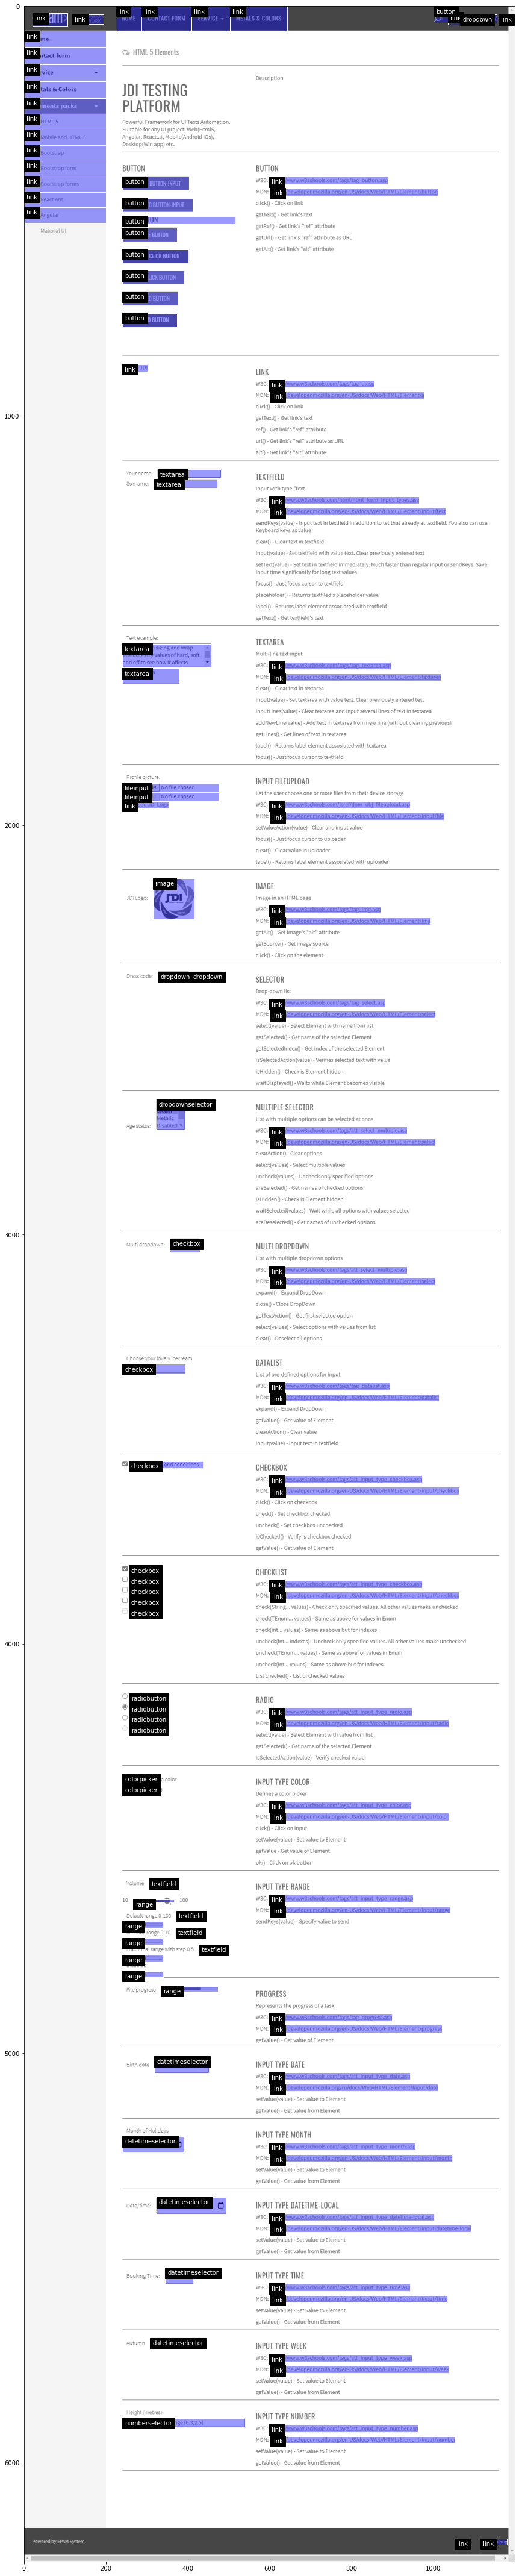

In [19]:
IMG_SIZE = 15
_h = _img.shape[0]/_img.shape[1]*IMG_SIZE
_w = IMG_SIZE

plt.figure(figsize=(_w, _h))
plt.imshow(_img, cmap='gray')
axes = plt.gca()

for i, r in df_with_labels[~df_with_labels.label.isna()].iterrows():
    r.x, r.y, r.width, r.height
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=1 ,edgecolor='blue', facecolor='blue', alpha=.4)
    axes.add_patch(patch)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=1 ,edgecolor='white', facecolor='none', alpha=1.0)
    plt.text(r.x+6, r.y+17, classes[int(r.label)], color = 'white', backgroundcolor='black', alpha=1.0)
    axes.add_patch(patch)
    
plt.show()


In [20]:
test_df = pd.read_parquet(f'dataset/df/{page_name}.parquet')

In [21]:
test_img = plt.imread(f'dataset/images/{page_name}.png')
print(test_img.shape)
test_df = assign_labels(df=test_df, 
                        annotations_file_path=f'dataset/annotations/{page_name}.txt' ,
                        img=test_img)

(6242, 1200, 4)


Assigning labels:   0%|          | 0/118 [00:00<?, ?it/s]

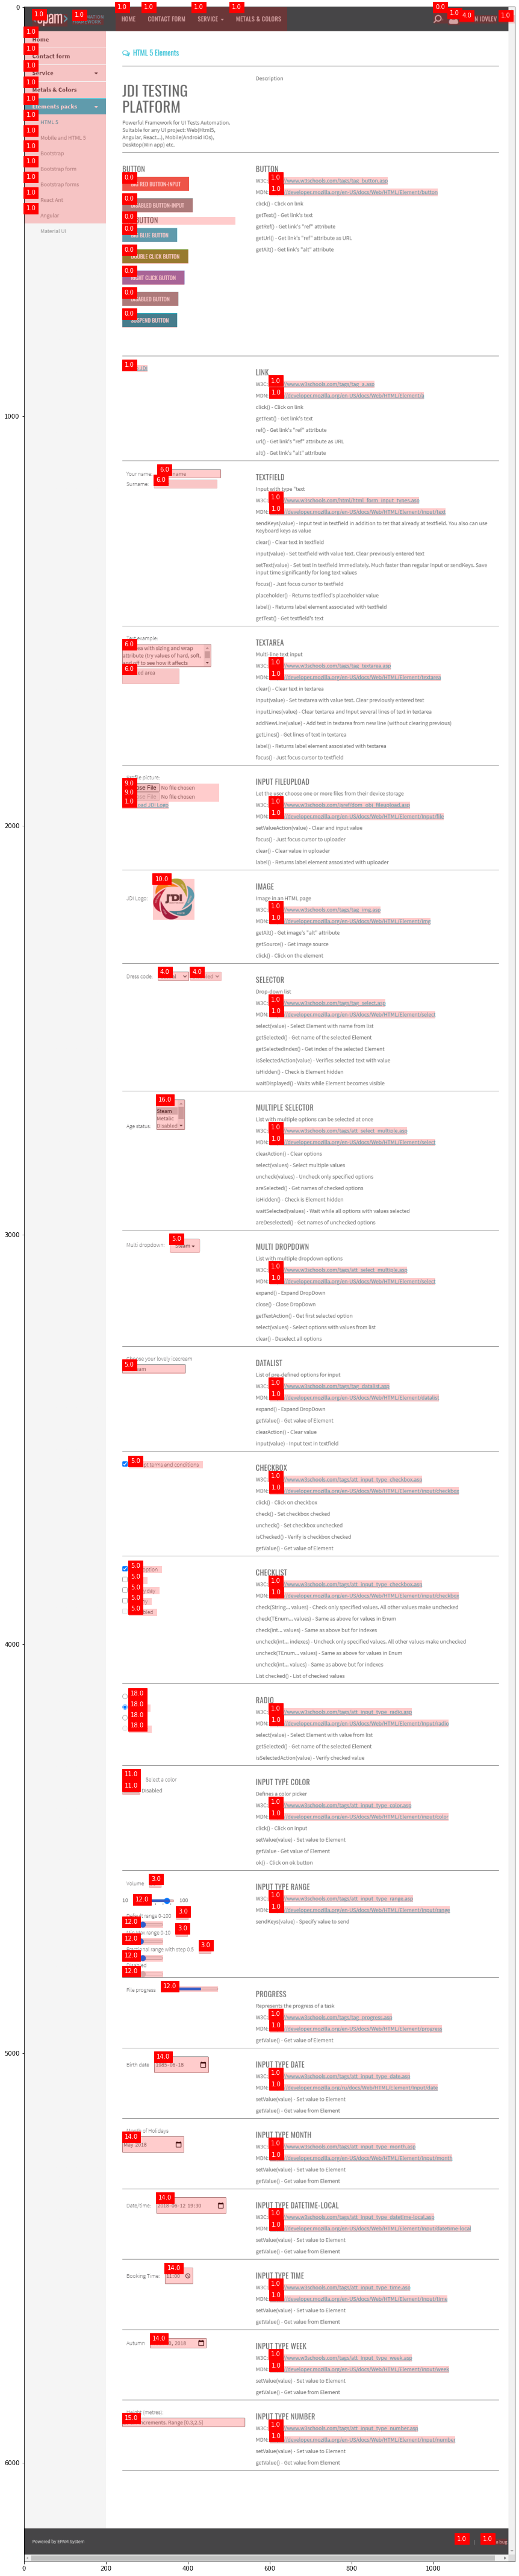

In [22]:
IMG_SIZE = 15
_h = test_img.shape[0]/test_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(test_img, cmap='gray')
axes = plt.gca()

for i, r in test_df[test_df.label != -1].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+5, r.y+5, r.label, color='white', backgroundcolor='red')
